## ECE495 Inhibitory Neurons - Tutorial

This tutorial covers the following:
- Performing inhibitions with neurons
- How to interpret results _as you go_ and adjust code to get the results you want

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.processes import Piecewise
from nengo.dists import Uniform

### Motivation

There's [a tutorial](https://www.nengo.ai/nengo/examples/advanced/inhibitory-gating.html) provided by the Nengo creators where a neuron ensemble is used to inhibit another. This got me thinking - we should be able to use neurons to inhibit our map neurons in our path planning algorithm. 


### Attempt 1

So... I tried. I got rid of my inhibition function within my delay node and I began by feeding back my neuron output at each map location to its own delay node with a transform of -10, much like what the tutorial did:

`nengo.Connection(map_neurons[i], delay_nodes[i], transform=[[-10]])`

For my 3x3 map, I sometimes got the right path (which of course led me to believe something wasn't right), but the neuron outputs were all over the place! Let's take a look (Keys v1 and v2). I now had negative outputs all over the place! and the whole point is to make everything go to zero.

_NOTE: when trying to figure out what's going wrong with my code, I looked at each neuron's output to see if it made sense to me._ If you are still running into issues with your lab, START DOING THIS.

**How could I make all values go to zero instead of allowing any negative representations??**

### Attempt 2

I adjusted my encoders and intercepts to only allow positive values through. Let's look at the results (KEY v2B). 

_NOT GOOD._ I no longer have negative values, but I'm spiking forever! I'm not actually inhibiting anything!

I was infuriated! I knew this should work, ranted about it, and was given the recommendation to try it with just one neuron, so here we go.

### One Neuron Testing - Attempt 3

This is something you will want to do on your final project: _start small_

Using just one neuron, I learned SO MUCH.

In [ ]:
model = nengo.Network(label="OneNeuronInhibition")
with model:
    inp_node = nengo.Node(
        Piecewise({0: 1, 0.25: 0, 3: 1})
    )  # quick spike into start node

    n_neurons_map = 500
    map_neurons = nengo.Ensemble(
        n_neurons=n_neurons_map,
        dimensions=1,
        intercepts=Uniform(0, 0.9),
        encoders=np.tile([[1]], (n_neurons_map, 1)),
    )

    nengo.Connection(inp_node, map_neurons)
    nengo.Connection(map_neurons, map_neurons, transform=[[-10]])  # inhibition feedback

    map_probes = nengo.Probe(map_neurons, synapse=0.01)
    inp_probe = nengo.Probe(inp_node, synapse=0.01)

sim_time = 4
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(sim_time)

plt.figure()
plt.plot(sim.trange(), sim.data[inp_probe], label="Input")
plt.plot(sim.trange(), sim.data[map_probes], label="Neuron")
plt.legend(loc=1)
plt.xlabel("time [s]")
plt.title("One Neuron - Attempt 3")
plt.show()

Okay, reasons this isn't good:
- The amplitude TANKED. There's no way that's making it all the way through a map.
- It still spikes later.

**Why do you think this is??**

### One Neuron Testing - Attempt 4

Because neurons constantly spike and feedback, we start inhibiting right away so we lose a lot. 

Let's add a delay so the whole spike makes it through, then we inhibit!

In [ ]:
# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]


dt = 0.001
timesteps = 0.25
delay = Delay(1, timesteps=int(timesteps / dt))

model = nengo.Network(label="OneNeuronInhibition2")
with model:
    inp_node = nengo.Node(
        Piecewise({0: 1, 0.25: 0, 3: 1})
    )  # quick spike into start node

    delay_node = nengo.Node(delay.step, size_in=1, size_out=1)

    n_neurons_map = 500
    map_neurons = nengo.Ensemble(
        n_neurons=n_neurons_map,
        dimensions=1,
        intercepts=Uniform(0, 0.9),
        encoders=np.tile([[1]], (n_neurons_map, 1)),
    )

    nengo.Connection(inp_node, map_neurons)
    nengo.Connection(map_neurons, delay_node)
    nengo.Connection(delay_node, map_neurons, transform=[[-10]])  # inhibition feedback

    map_probes = nengo.Probe(map_neurons, synapse=0.01)
    delay_probe = nengo.Probe(delay_node, synapse=0.01)
    inp_probe = nengo.Probe(inp_node, synapse=0.01)

sim_time = 4
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(sim_time)

plt.figure()
plt.plot(sim.trange(), sim.data[inp_probe], label="Input")
plt.plot(sim.trange(), sim.data[delay_probe], label="Delay")
plt.plot(sim.trange(), sim.data[map_probes], label="Neuron")
plt.legend()
plt.xlabel("time [s]")
plt.title("One Neuron - Attempt 4")
plt.show()

My amplitude is back (yay?), but
- I still fire later
- For a constant input, I only inhibit for the duration of the delay

We are getting somewhere, **but what else could we do??**

We need a neuron that once it starts firing, it never stops firing. **Where have we seen that happen before?**


### One Neuron Testing - Attempt 5

We add a dedicated inhibition neuron!

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

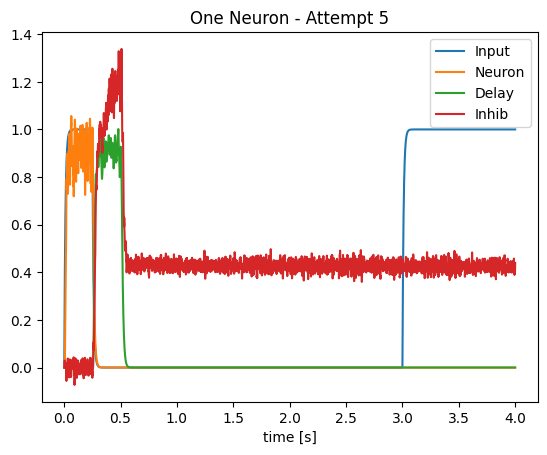

In [2]:
# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]


dt = 0.001
timesteps = 0.25
delay = Delay(1, timesteps=int(timesteps / dt))

model = nengo.Network(label="OneNeuronInhibition")
with model:
    inp_node = nengo.Node(
        Piecewise({0: 1, 0.25: 0, 3: 1})
    )  # quick spike into start node

    delay_node = nengo.Node(delay.step, size_in=1, size_out=1)

    n_neurons_map = 500
    map_neurons = nengo.Ensemble(
        n_neurons=n_neurons_map,
        dimensions=1,
        intercepts=Uniform(0, 0.9),
        encoders=np.tile([[1]], (n_neurons_map, 1)),
    )

    inhibition_neuron = nengo.Ensemble(
        n_neurons=n_neurons_map, dimensions=1, max_rates=Uniform(100, 100)
    )

    nengo.Connection(inp_node, map_neurons)
    nengo.Connection(map_neurons, delay_node)
    nengo.Connection(delay_node, inhibition_neuron)
    nengo.Connection(inhibition_neuron, inhibition_neuron, synapse=0.5)
    nengo.Connection(
        inhibition_neuron, map_neurons, transform=[[-10]]
    )  # inhibition feedback

    map_probes = nengo.Probe(map_neurons, synapse=0.01)
    delay_probe = nengo.Probe(delay_node, synapse=0.01)
    inhib_probe = nengo.Probe(inhibition_neuron, synapse=0.01)
    inp_probe = nengo.Probe(inp_node, synapse=0.01)

sim_time = 4
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(sim_time)

plt.figure()
plt.plot(sim.trange(), sim.data[inp_probe], label="Input")
plt.plot(sim.trange(), sim.data[map_probes], label="Neuron")
plt.plot(sim.trange(), sim.data[delay_probe], label="Delay")
plt.plot(sim.trange(), sim.data[inhib_probe], label="Inhib")
plt.legend(loc=1)
plt.xlabel("time [s]")
plt.title("One Neuron - Attempt 5")
plt.show()

LOOK AT THAT BEAUTY! 

We get excited. We build a whole new neuron class. We throw it into our path planning algorithm and....

Let's take a look (KEY v3).

We have random neurons throughout the map spiking at the same time as the starting location?! That's not possible if we have delays (especially if we know this thing worked before we started these shenanigans).

We look neuron by neuron and see that the delay sees nothing, the neuron just... fires?

**Why on earth does this thing start randomly firing??**

### One Neuron Testing - Attempt 6

Back to one (freaking) neuron.

We adjust our input to look more like a neuron that's waiting on a spike wave.

In [ ]:
# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        # determine if its spiked and turn to 0
        return self.history[0]


dt = 0.001
timesteps = 0.25
delay = Delay(1, timesteps=int(timesteps / dt))

model = nengo.Network(label="OneNeuronInhibition")
with model:
    inp_node = nengo.Node(
        Piecewise({0: 0, 1: 1, 1.25: 0, 2: 1})
    )  # quick spike into start node

    delay_node = nengo.Node(delay.step, size_in=1, size_out=1)

    n_neurons_map = 500
    map_neurons = nengo.Ensemble(
        n_neurons=n_neurons_map,
        dimensions=1,
        intercepts=Uniform(0, 0.9),
        encoders=np.tile([[1]], (n_neurons_map, 1)),
    )

    inhibition_neuron = nengo.Ensemble(
        n_neurons=n_neurons_map, dimensions=1, max_rates=Uniform(100, 100)
    )

    nengo.Connection(inp_node, map_neurons)
    nengo.Connection(map_neurons, delay_node)
    nengo.Connection(delay_node, inhibition_neuron)
    nengo.Connection(inhibition_neuron, inhibition_neuron, synapse=0.5)
    nengo.Connection(
        inhibition_neuron, map_neurons, transform=[[-10]]
    )  # inhibition feedback

    map_probes = nengo.Probe(map_neurons, synapse=0.01)
    delay_probe = nengo.Probe(delay_node, synapse=0.01)
    inhib_probe = nengo.Probe(inhibition_neuron, synapse=0.01)
    inp_probe = nengo.Probe(inp_node, synapse=0.01)

sim_time = 4
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(sim_time)

plt.figure()
plt.plot(sim.trange(), sim.data[inp_probe], label="Input")
plt.plot(sim.trange(), sim.data[map_probes], label="Neuron")
plt.plot(sim.trange(), sim.data[delay_probe], label="Delay")
plt.plot(sim.trange(), sim.data[inhib_probe], label="Inhib")
plt.legend(loc=1)
plt.xlabel("time [s]")
plt.title("One Neuron - Attempt 6")
plt.show()

GROSS. Okay, so this is representative of what's happening throughout my map.

**Why is it SO noisy at the start?!**

### One Neuron Testing - Attempt 7 

Okay, so now we decrease the weight of the feedback transform. The minor noise gets amplified to the point that the map neuron thinks it's an input and we get a false first spike. Let's dial it back:

In [ ]:
# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]


dt = 0.001
timesteps = 0.25
delay = Delay(1, timesteps=int(timesteps / dt))

model = nengo.Network(label="OneNeuronInhibition")
with model:
    inp_node = nengo.Node(
        Piecewise({0: 0, 1: 1, 1.25: 0, 2: 1})
    )  # quick spike into start node

    delay_node = nengo.Node(delay.step, size_in=1, size_out=1)

    n_neurons_map = 500
    map_neurons = nengo.Ensemble(
        n_neurons=n_neurons_map,
        dimensions=1,
        intercepts=Uniform(0, 0.9),
        encoders=np.tile([[1]], (n_neurons_map, 1)),
    )

    inhibition_neuron = nengo.Ensemble(
        n_neurons=n_neurons_map, dimensions=1, max_rates=Uniform(100, 100)
    )

    nengo.Connection(inp_node, map_neurons)
    nengo.Connection(map_neurons, delay_node)
    nengo.Connection(delay_node, inhibition_neuron)
    nengo.Connection(inhibition_neuron, inhibition_neuron, synapse=0.5)
    nengo.Connection(
        inhibition_neuron, map_neurons, transform=[[-1]]
    )  # inhibition feedback

    map_probes = nengo.Probe(map_neurons, synapse=0.01)
    delay_probe = nengo.Probe(delay_node, synapse=0.01)
    inhib_probe = nengo.Probe(inhibition_neuron, synapse=0.01)
    inp_probe = nengo.Probe(inp_node, synapse=0.01)

sim_time = 4
with nengo.Simulator(model) as sim:
    # Run it for 2 seconds
    sim.run(sim_time)

plt.figure()
plt.plot(sim.trange(), sim.data[inp_probe], label="Input")
plt.plot(sim.trange(), sim.data[map_probes], label="Neuron")
plt.plot(sim.trange(), sim.data[delay_probe], label="Delay")
plt.plot(sim.trange(), sim.data[inhib_probe], label="Inhib")
plt.legend(loc=1)
plt.xlabel("time [s]")
plt.title("One Neuron - Attempt 7")
plt.show()

Now we don't inhibit enough!!

### Attempts 8 to ???

We can find the perfect feedback weight for one neuron here, but it still throws issues when we turn back to our path planning maps. 

Some ideas:
- Add a weight to the inhibition neuron to make it saturate faster. This kind of works, but it depends on how long your delay is before you get a spike. And you have to have the perfect balance of the OG feedback weight and the inhibition feedback weight, which is NOT generalizable.
- Change your intercepts to wait to fire until the values are higher. Works better but not great.
- Stick with fancy nodes that do the thing correctly.
- **Any other ideas??**

### Discussion

For your final project, I will not have a key for each of your topics to reference and assist with debugging. You will need to be able to problem solve by looking at your neuron outputs and thinking through how things can be adjusted indepedent of me (first), then come to me to work things out.

_My hope is that your Lab2 gives you the confidence to understand an algorithm well enough to map it to neurons AND to do hard things with Python (like indexing)._  

_My hope is that this tutorial gives you a bit of a framework on how to problem solve complicated neuron problems when you're REALLY solo_:
- Look at individual neuron outputs in your larger model
- When something looks off, go to one neuron and ensure what you think should be happening is what is in fact happening
- Repeat!